In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn import datasets, manifold, neighbors
import networkx as nx
from GraphRicciCurvature.OllivierRicci import OllivierRicci
import gtda.graphs as gtg

<frozen importlib._bootstrap>:219: ReducedFunctionalityWarning: WARNING: module 'pandas' not found, some functionality will be restricted


In [2]:
# Data generation functions

def concentric_circles(n_samples, factor, noise):
    """ 
    Generate concentric circles with noise. 
    Parameters
    
    n_samples : int
        The number of samples to generate.
    factor : float
        The scaling factor between the circles.
    noise : float
        The standard deviation of the Gaussian noise.

    Returns
    -------
    X : array-like, shape (n_samples, 2)
        The generated samples.
    
    y : array-like, shape (n_samples,)
        The integer labels for class membership of each sample.
    """
    X, y = datasets.make_circles(n_samples=n_samples, noise=noise, factor=factor)
    return X, y

def swiss_roll(n_points, noise, dim=3):
    """
    Generate a Swiss roll dataset.
    Parameters
    ----------
    n_points : int
        The number of points to generate.
    noise : float
        The standard deviation of the Gaussian noise.
    Returns
    -------
    swiss_roll : array-like, shape (n_points, dim)
        The generated Swiss roll.
    color : array-like, shape (n_points,)
        The color of each point.
    dim: int
        The dimension of the Swiss roll.
    """
    swiss_roll, color = datasets.make_swiss_roll(n_points, noise=noise)
    if dim == 2:
        swiss_roll = swiss_roll[:, [0, 2]]
    return swiss_roll, color

In [82]:
# method

def make_prox_graph(X, mode='nbrs', n_neighbors=None, epsilon=None):
    """
    Create a proximity graph from a dataset.
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        The dataset.
    mode : str, optional
        The mode of the graph construction. Either 'nbrs' or 'eps'.
    n_neighbors : int, optional
        The number of neighbors to consider when mode='nbrs'.
    epsilon : float, optional
        The epsilon parameter when mode='eps'.
    Returns
    -------
    G : networkx.Graph
        The proximity graph.
    """
    
    if mode == 'nbrs':
        assert n_neighbors is not None, "n_neighbors must be specified when mode='nbrs'."
        A = neighbors.kneighbors_graph(X, n_neighbors=n_neighbors, mode='distance')
    elif mode == 'eps':
        assert epsilon is not None, "epsilon must be specified when mode='eps'."
        A = neighbors.radius_neighbors_graph(X, radius=epsilon, mode='distance')
    else:
        raise ValueError("Invalid mode. Choose 'nbrs' or 'eps'.")

    # convert to networkx graph and symmetrize A
    n_points = X.shape[0]
    G = nx.Graph()
    for i in range(n_points):
        for j in range(i+1, n_points):
            if A[i, j] > 0:
                G.add_edge(i, j, weight=A[i, j])

    assert G.is_directed() == False, "The graph is directed."
    return G, A


def adjust_orcs(orcs):
    """
    Adjust the Ollivier-Ricci curvatures to lie within 2 standard deviations of the mean.
    Parameters
    ----------
    orcs : array-like, shape (n_edges,)
        The Ollivier-Ricci curvatures.
    Returns
    -------
    adjusted_orcs : array-like, shape (n_edges,)
        The adjusted Ollivier-Ricci curvatures.
    """
    orcs = np.array(orcs)
    mean = np.mean(orcs)
    std = np.std(orcs)
    adjusted_orcs = np.clip(orcs, mean - 2*std, mean + 2*std)
    adjusted_orcs = (adjusted_orcs - adjusted_orcs.min()) / (adjusted_orcs.max() - adjusted_orcs.min())
    return adjusted_orcs

def graph_orc(G, weight='weight', alpha=0.5):
    """
    Compute the Ollivier-Ricci curvature on edges of a graph.
    Parameters
    ----------
    G : networkx.Graph
        The graph.
    weight : str
        The edge attribute to use as the weight.
    alpha : float
        The alpha parameter for the Ollivier-Ricci curvature.
    Returns
    -------
    G : networkx.Graph
        The graph with the Ollivier-Ricci curvatures as edge attributes.
    """
    orc = OllivierRicci(G, weight=weight, alpha=alpha, verbose='INFO')
    orc.compute_ricci_curvature()
    orcs = []
    for i, j, _ in orc.G.edges(data=True):
        orcs.append(orc.G[i][j]['ricciCurvature'])
    # adjust the Ollivier-Ricci curvatures
    adjusted_orcs = adjust_orcs(orcs)
    # reassign the adjusted Ollivier-Ricci curvatures to the graph
    for idx, (i, j, _) in enumerate(orc.G.edges(data=True)):
        orc.G[i][j]['ricciCurvature'] = adjusted_orcs[idx]
    return orc.G, adjusted_orcs


def prune(G, threshold, X, color):
    """
    Prune the graph based on a threshold. Adjust the node coordinates and colors accordingly.
    Parameters
    ----------
    G : networkx.Graph
        The graph to prune.
    threshold : float
        The threshold for the scaled Ollivier-Ricci curvature.
    Returns
    -------
    G_pruned : networkx.Graph
        The pruned graph.
    """
    G_pruned = nx.Graph()
    preserved_nodes = set()
    for i, j, d in G.edges(data=True):
        if d['ricciCurvature'] > threshold:
            G_pruned.add_edge(i, j, weight=d['weight'])
            preserved_nodes.add(i)
            preserved_nodes.add(j)
            G_pruned[i][j]['ricciCurvature'] = d['ricciCurvature']
    
    preserved_orcs = []
    for i, j, d in G_pruned.edges(data=True):
        preserved_orcs.append(d['ricciCurvature'])

    X_pruned = X[list(preserved_nodes)]
    color_pruned = color[list(preserved_nodes)]
    
    print(f'Percentage of edges preserved: {len(G_pruned.edges) / len(G.edges)}')
    return {
        'G_pruned': G_pruned,
        'preserved_nodes': preserved_nodes,
        'X_pruned': X_pruned,
        'color_pruned': color_pruned,
        'preserved_orcs': preserved_orcs
    }


In [4]:
# plotting functions

def plot_data_2D(X, y, title):
    """
    Plot the data with the points colored by class membership.
    Parameters
    
    X : array-like, shape (n_samples, 2)
        The coordinates of the points.
    y : array-like, shape (n_samples,)
        The integer labels for class membership of each point.
    title : str
        The title of the plot.
    """
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.title(title)
    plt.gca().set_aspect('equal')
    plt.gca().set_axis_off()
    plt.show()

def plot_graph_2D(X, graph, title, node_color='#1f78b4', edge_color='lightgray', node_size=10, colorbar=False):
    """
    Plot the graph with the desired node or edge coloring.
    Parameters
    
    X : array-like, shape (n_samples, 2)
        The coordinates of the nodes.
    graph : networkx.Graph
        The graph to plot.
    title : str
        The title of the plot.
    node_color : str
        The color of the nodes.
    edge_color : str
        The color of the edges.
    """
    nx.draw(graph, X, node_color=node_color, edge_color=edge_color, node_size=node_size, cmap=plt.cm.Spectral, edge_cmap=plt.cm.coolwarm, edge_vmin=0, edge_vmax=1)
    # nx.draw(graph, X, node_color=node_color, cmap=plt.cm.Spectral, node_size=node_size)
    plt.title(title)
    plt.gca().set_aspect('equal')
    if colorbar:
        sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=0, vmax=1))
        sm._A = []
        plt.colorbar(sm)
    plt.show()

def plot_emb(Y, color, title):
    """
    Plot the embedding of the data.
    Parameters
    
    Y : array-like, shape (n_samples, 2)
        The coordinates of the points in the embedding.
    title : str
        The title of the plot.
    """
    if Y.shape[1] == 1:
        plt.scatter(Y, np.zeros(Y.shape), c=color, cmap=plt.cm.Spectral, s=10)
    else:
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=10)
    plt.title(title)
    plt.gca().set_axis_off()
    plt.show()

In [114]:
# embeddings

def spectral_embedding(A, n_components):
    """
    Compute the spectral embedding of a graph.
    Parameters
    ----------
    A : array-like, shape (n_samples, n_samples)
        The adjacency matrix of the graph.
    n_components : int
        The number of components to keep.
    Returns
    -------
    Y : array-like, shape (n_samples, n_components)
        The spectral embedding of the graph.
    """
    se = manifold.SpectralEmbedding(n_components=n_components, affinity='precomputed')
    Y = se.fit_transform(A)
    return Y
    
def isomap(A, n_components):
    """
    Compute the Isomap embedding of a graph.
    Parameters
    ----------
    A : array-like, shape (n_samples, n_samples)
        The adjacency matrix of the graph.
    n_components : int
        The number of components to keep.
    Returns
    -------
    Y : array-like, shape (n_samples, n_components)
        The Isomap embedding of the graph.
    """

    # isomap with precomputed distances
    iso = manifold.Isomap(metric='precomputed', n_components=n_components)
    # compute geodesic distances
    distances = scipy.sparse.csgraph.shortest_path(A, directed=False)
    assert np.allclose(distances, distances.T), "The distance matrix is not symmetric."
    Y = iso.fit_transform(distances)
    return Y

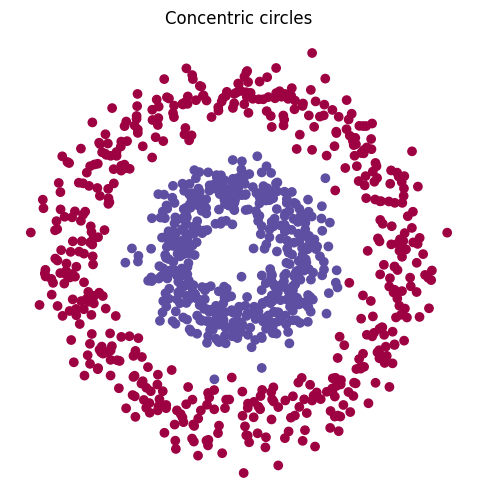

In [104]:
n_points = 1000
X, color = concentric_circles(n_points, factor=0.4, noise=0.1)
plot_data_2D(X, color, 'Concentric circles')

/home/tristan/envs/orcml/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


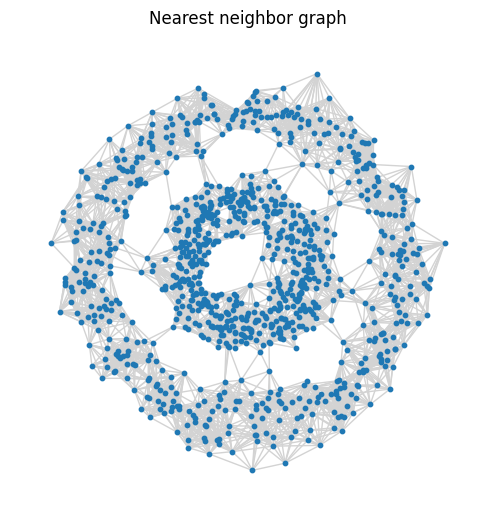

In [105]:
n_neighbors = 20
G, A = make_prox_graph(X, mode='nbrs', n_neighbors=n_neighbors)
plot_graph_2D(X, G, 'Nearest neighbor graph')

/home/tristan/envs/orcml/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


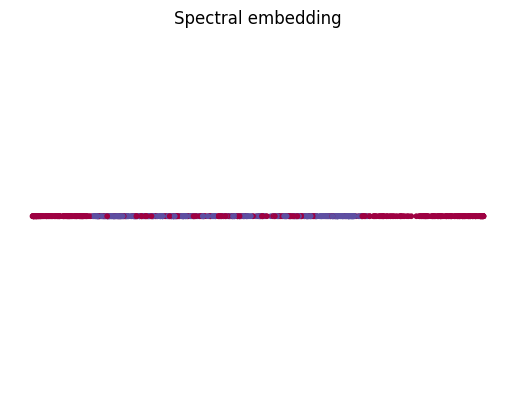

In [106]:
# run spectral embedding
Y = spectral_embedding(A, n_components=1)
plot_emb(Y, color, 'Spectral embedding')

/tmp/ipykernel_90197/4135540724.py:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


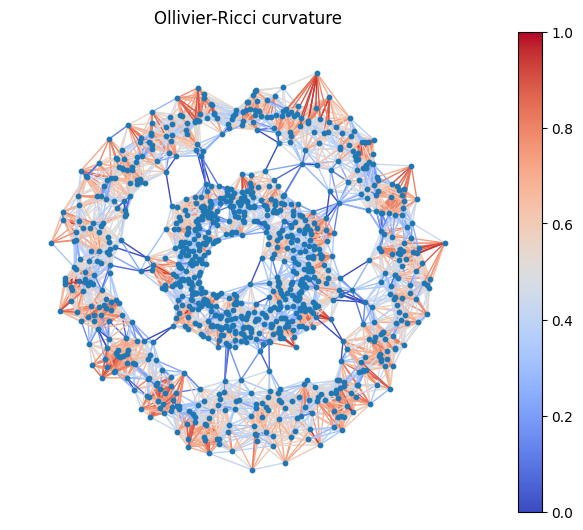

In [107]:
G_orc, orc_weights = graph_orc(G, weight='weight', alpha=0.5)
plot_graph_2D(X, G_orc, 'Ollivier-Ricci curvature', edge_color=orc_weights, colorbar=True)

Percentage of edges preserved: 0.7342427561485612


/tmp/ipykernel_90197/4135540724.py:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


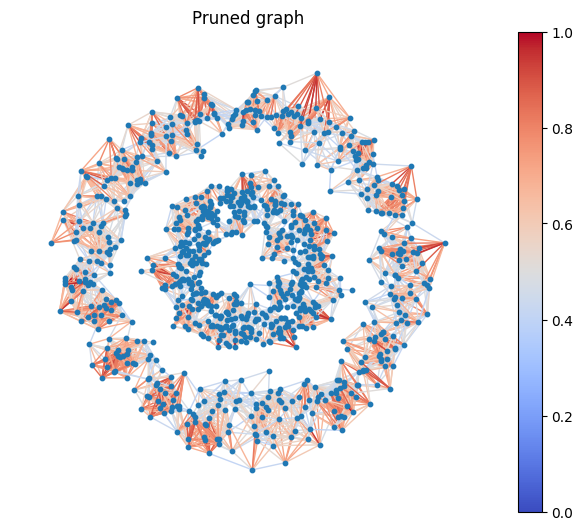

In [108]:
threshold = 0.4
pruned = prune(G_orc, threshold, X, color)
plot_graph_2D(X, pruned['G_pruned'], 'Pruned graph', edge_color=pruned['preserved_orcs'], colorbar=True)

/home/tristan/envs/orcml/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


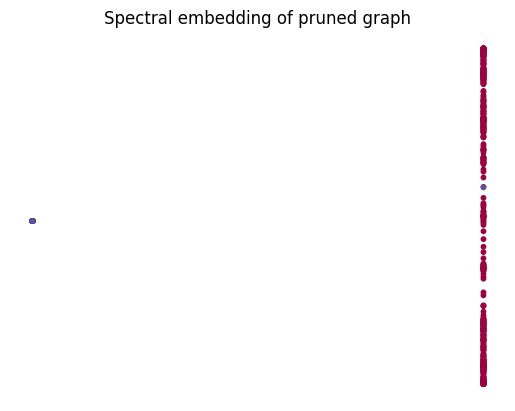

In [109]:
# run spectral embedding on pruned graph

A = nx.adjacency_matrix(pruned['G_pruned']).toarray()
Y = spectral_embedding(A, n_components=2)

plot_emb(Y, color[nx.nodes(pruned['G_pruned'])], 'Spectral embedding of pruned graph')

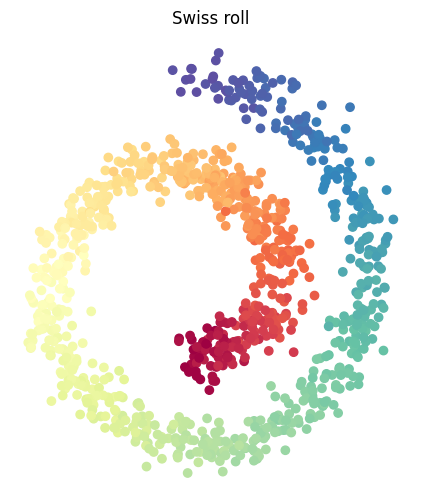

In [116]:
# swiss roll
swiss_roll_data, color = swiss_roll(n_points, noise=0.9, dim=2)
plot_data_2D(swiss_roll_data, color, 'Swiss roll')

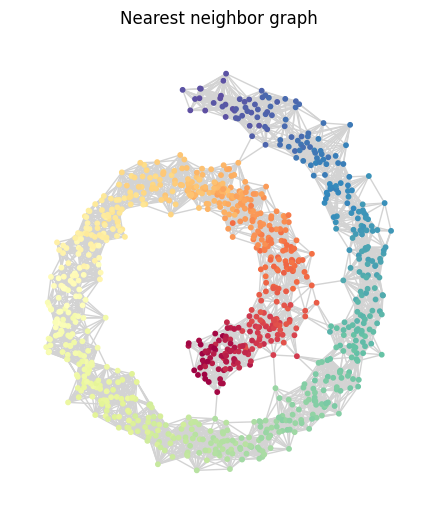

In [117]:
n_neighbors = 20
G, A = make_prox_graph(swiss_roll_data, mode='nbrs', n_neighbors=n_neighbors)
plot_graph_2D(swiss_roll_data, G, 'Nearest neighbor graph', node_color=color[nx.nodes(G)])

/home/tristan/envs/orcml/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


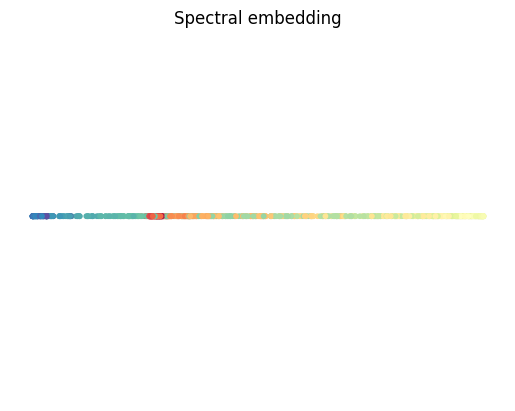

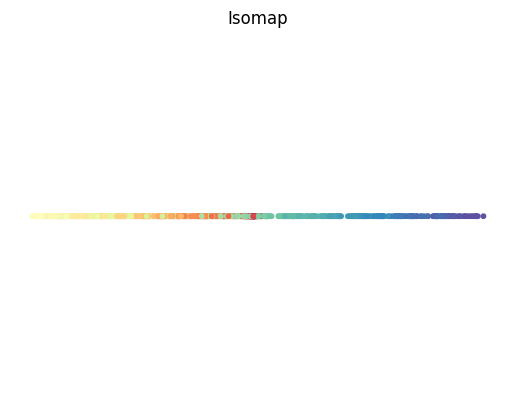

In [118]:
n_components = 1
Y_spectral = spectral_embedding(A, n_components=n_components)
plot_emb(Y_spectral, color, 'Spectral embedding')

Y_isomap = isomap(A, n_components=1)
plot_emb(Y_isomap, color, 'Isomap')

/home/tristan/envs/orcml/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
/tmp/ipykernel_90197/4135540724.py:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


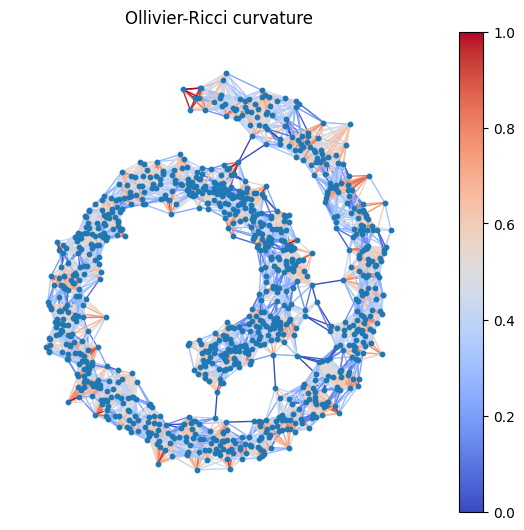

In [119]:
G_orc, orc_weights = graph_orc(G, weight='weight', alpha=0.5)
plot_graph_2D(swiss_roll_data, G_orc, 'Ollivier-Ricci curvature', edge_color=orc_weights, colorbar=True)

Percentage of edges preserved: 0.9508621548888667


/tmp/ipykernel_90197/4135540724.py:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


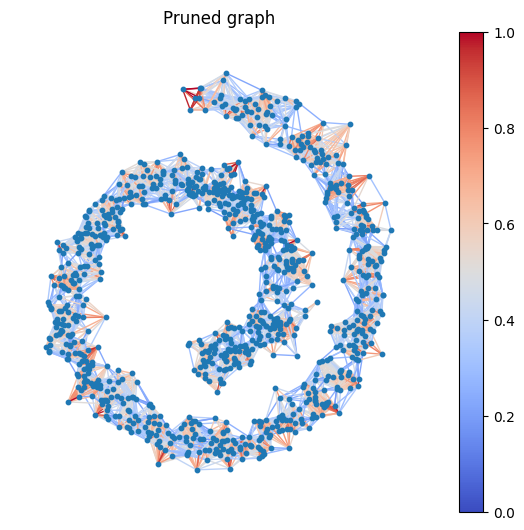

In [120]:
threshold = 0.2
pruned = prune(G_orc, threshold, swiss_roll_data, color)
plot_graph_2D(swiss_roll_data, pruned['G_pruned'], 'Pruned graph', edge_color=pruned['preserved_orcs'], colorbar=True)

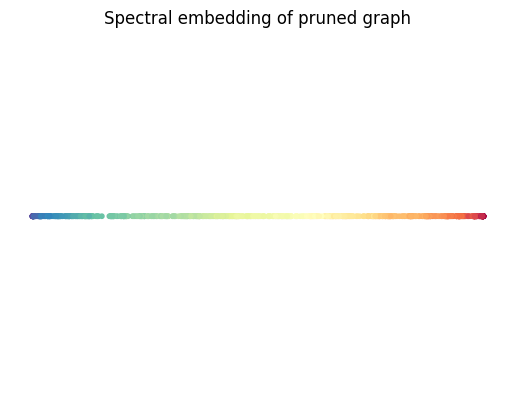

/home/tristan/envs/orcml/lib/python3.8/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/tristan/envs/orcml/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


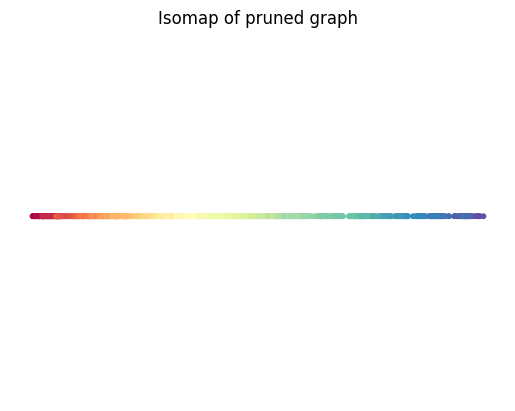

In [122]:
# run spectral embedding on pruned graph
A = nx.adjacency_matrix(pruned['G_pruned']).toarray()
colors = pruned['color_pruned'][list(pruned['G_pruned'])]
Y = spectral_embedding(A, n_components=1)
plot_emb(Y, colors, 'Spectral embedding of pruned graph')

# run isomap on pruned graph
Y = isomap(A, n_components=1)
plot_emb(Y, colors, 'Isomap of pruned graph')